<a href="https://colab.research.google.com/github/samthomaz/skincancer_detector/blob/main/skin_cancer_detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Google Colab Setup and Loading Dataset**

In [ ]:
from google.colab import files
files.upload()

In [72]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download HAM10000 Dataset
!kaggle datasets download kmader/skin-cancer-mnist-ham10000
!ls
!unzip skin-cancer-mnist-ham10000.zip
!ls

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
^C
 ham10000_images_part_1   hmnist_28_28_L.csv	'kaggle (2).json'
 HAM10000_images_part_1   hmnist_28_28_RGB.csv	 kaggle.json
 ham10000_images_part_2   hmnist_8_8_L.csv	 sample_data
 HAM10000_images_part_2   hmnist_8_8_RGB.csv	 skin-cancer-mnist-ham10000.zip
 HAM10000_metadata.csv	 'kaggle (1).json'
Archive:  skin-cancer-mnist-ham10000.zip
replace HAM10000_images_part_1/ISIC_0024306.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024307.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024308.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024309.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024310.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_images_part_1/ISIC_0024311.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace HAM10000_

 ham10000_images_part_1   hmnist_28_28_L.csv	'kaggle (2).json'
 HAM10000_images_part_1   hmnist_28_28_RGB.csv	 kaggle.json
 ham10000_images_part_2   hmnist_8_8_L.csv	 sample_data
 HAM10000_images_part_2   hmnist_8_8_RGB.csv	 skin-cancer-mnist-ham10000.zip
 HAM10000_metadata.csv	 'kaggle (1).json'
Total images:  10015


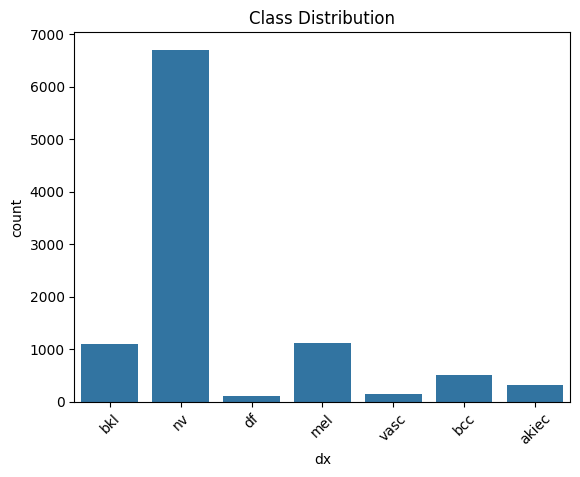

In [73]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

!ls

df = pd.read_csv('HAM10000_metadata.csv')
df.head()

print("Total images: ", len(df))

sns.countplot(x='dx', data=df) #dx=diagnosis
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

#Diagnosis contains 7 values:
#Melanocytic nevus (nv), Melanoma(mel),Benign keratosis(bkl),Basal cell carcinoma(bcc),Actinic keratoses (pre-cancer)(akiec),Dermatofibroma(df),Vascular lesions(vasc)

In [74]:
df['label'] = df['dx'].apply(lambda x: 1 if x == 'mel' else 0)
print(df['label'].value_counts())

label
0    8902
1    1113
Name: count, dtype: int64


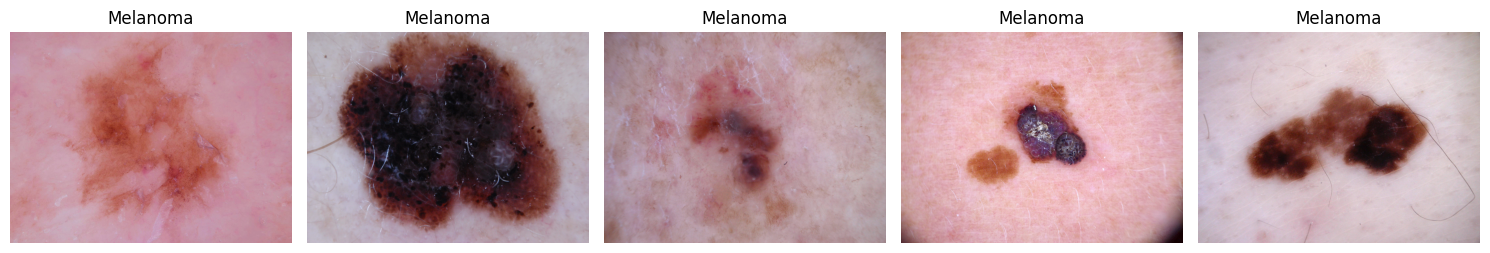

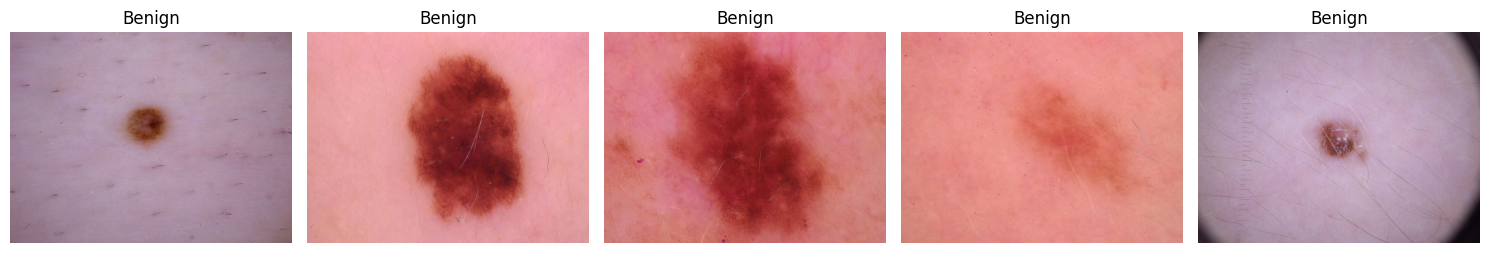

In [75]:
import matplotlib.pyplot as plt

def show_images(df, label, n=5):
  subset = df[df['label'] == label].sample(n)
  plt.figure(figsize=(15, 5))
  for i, row in enumerate(subset.itertuples()):
    image_path = os.path.join('HAM10000_images_part_1', row.image_id + '.jpg')
    if not os.path.exists(image_path):
      image_path = os.path.join('HAM10000_images_part_2', row.image_id + '.jpg')
    image = Image.open(image_path)
    plt.subplot(1, n, i+1)
    plt.imshow(image)
    plt.title('Melanoma' if row.label == 1 else 'Benign')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

show_images(df, label=1) # Melanoma
show_images(df, label=0) # Benign

# **Preprocessing & Dataset Preparation**

In [76]:
import os

#Code block will aid to get the correct image path
def get_image_path(image_id):
  part1 = os.path.join('HAM10000_images_part_1', image_id + '.jpg')
  part2 = os.path.join('HAM10000_images_part_2', image_id + '.jpg')
  return part1 if os.path.exists(part1) else part2

df['image_path'] = df['image_id'].apply(get_image_path)

df[['image_id', 'image_path', 'label']].head()

,image_id,image_path,label
0,ISIC_0027419,HAM10000_images_part_1/ISIC_0027419.jpg,0
1,ISIC_0025030,HAM10000_images_part_1/ISIC_0025030.jpg,0
2,ISIC_0026769,HAM10000_images_part_1/ISIC_0026769.jpg,0
3,ISIC_0025661,HAM10000_images_part_1/ISIC_0025661.jpg,0
4,ISIC_0031633,HAM10000_images_part_2/ISIC_0031633.jpg,0


In [77]:
mel_df = df[df['label'] == 1]
non_mel_df = df[df['label'] == 0].sample(len(mel_df), random_state=42)

balanced_df = pd.concat([mel_df, non_mel_df]).sample(frac=1).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
0    1113
1    1113
Name: count, dtype: int64


In [102]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255, #normalises image pixels from 0-255 to 0-1
    validation_split=0.2, #rsvs 20% of data for validation
    horizontal_flip=True, #adds data augmentation to make model more robust
    rotation_range=15,
    zoom_range=0.1
)

#creates batches of images and labels for training and validation sets
train_gen = datagen.flow_from_dataframe(
    balanced_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='training',
    shuffle=True
  )


validation_gen = datagen.flow_from_dataframe(
    balanced_df,
    x_col='image_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    subset='validation',
    shuffle=False
)

Found 1781 validated image filenames.
Found 445 validated image filenames.


# **Building and Training CNN model with Transfer Learning**

Transfer learning reuses "early layers" of pre-trained model (which detects edges, shapes, colours) and adds user defined custom output layer for the case (in this instance it is the melanoma detection).

MobielNetV2 will be used since

In [92]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Loading the base MobileNetV2 model (without top layers)
base_model = MobileNetV2(input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top =  False, #not to include ImageNet classification head
                         weights = 'imagenet') # use weights learnt from imagenet

#Freeze the base layers to only train the new top layers
base_model.trainable = False

In [93]:
#Adding Custom Layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [94]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

In [82]:
history = model.fit(
    train_gen,
    validation_data = validation_gen,
    epochs = 10,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5222 - loss: 0.8050 - val_accuracy: 0.6742 - val_loss: 0.5876
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.6287 - loss: 0.6557 - val_accuracy: 0.6831 - val_loss: 0.5666
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.6643 - loss: 0.6195 - val_accuracy: 0.7281 - val_loss: 0.5305
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.6804 - loss: 0.6047 - val_accuracy: 0.7506 - val_loss: 0.5064
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.6997 - loss: 0.5683 - val_accuracy: 0.7281 - val_loss: 0.5096
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.7289 - loss: 0.5425 - val_accuracy: 0.7236 - val_loss: 0.5163
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.7221 - loss: 0.5531 - val_accuracy: 0.7528 - val_loss: 0.4939
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.7566 - loss: 0.5188 - val_accuracy: 0.7483 - v

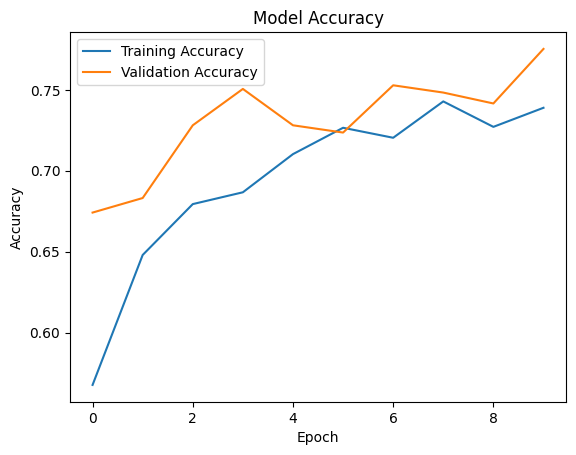

In [95]:
import matplotlib.pyplot as plt

#Accuracy plot
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Evaluate and Interpret the Model**

In [103]:
import numpy as np

# Reset generator so predictions align with true labels
validation_gen.reset()

# Predict
pred_probs = model.predict(validation_gen)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Get actual labels (this works ONLY if shuffle=False)
true_labels = validation_gen.labels

# Confirm shape matches
print("Predicted labels:", pred_labels.shape)
print("True labels:", true_labels.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Predicted labels: (445,)
True labels: (445,)


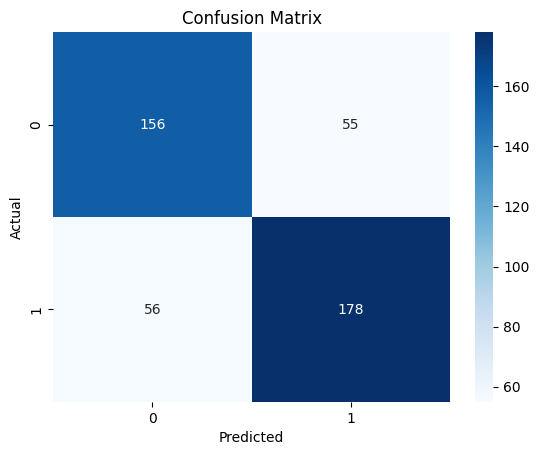

In [104]:
# Create a Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Confusion Matrix
cm = confusion_matrix(true_labels, prediction_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Precision, Recall and F1-score



*   Precision - out of all predicted melanoma cases, how many correct?
*   Recall - out of all actuall melanoma cases, how many caught?
*   F1 Score - Harmonic mean of precision and recall





In [105]:
print(classification_report(true_labels, pred_labels, target_names=["Benign", "Melanoma"]))


              precision    recall  f1-score   support

      Benign       0.38      0.14      0.21       211
    Melanoma       0.51      0.79      0.62       234

    accuracy                           0.49       445
   macro avg       0.45      0.47      0.41       445
weighted avg       0.45      0.49      0.42       445



# **Grad-CAM**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🔍 True Label: Benign
🤖 Model Prediction: Melanoma (0.86 confidence)


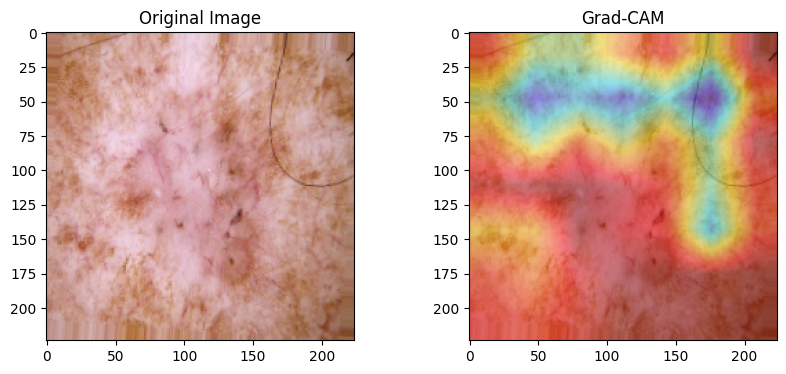

In [114]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Pick an image from the val set
img_array, label = validation_gen[0] # the batch of images and labels
img = img_array[0]
true_label = int(label[0])
img_expanded = np.expand_dims(img, axis=0)

# Get the last convolutional layer
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer("Conv_1_bn").output, model.output]
)

with tf.GradientTape() as tape:
  conv_outputs, predictions = grad_model(img_expanded)
  loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

#Multiply grads with feature maps
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs[0]), axis=-1)

# Normalize to 0–1
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Resize to match original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Overlay heatmap on original image
superimposed_img = cv2.addWeighted(np.uint8(img * 255), 0.6, heatmap_color, 0.4, 0)


# Run prediction on the image
pred_prob = model.predict(img_expanded)[0][0]
pred_label = int(pred_prob > 0.5)

# Show prediction and truth
print(f"🔍 True Label: {'Melanoma' if true_label == 1 else 'Benign'}")
print(f"🤖 Model Prediction: {'Melanoma' if pred_label == 1 else 'Benign'} ({pred_prob:.2f} confidence)")

# Show
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.title("Grad-CAM")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


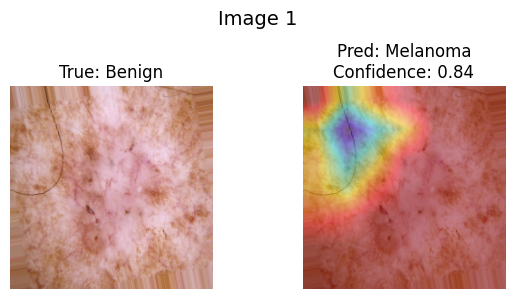

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


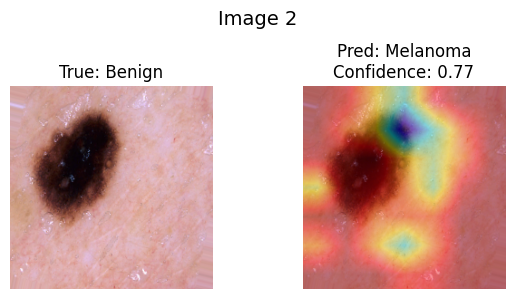

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


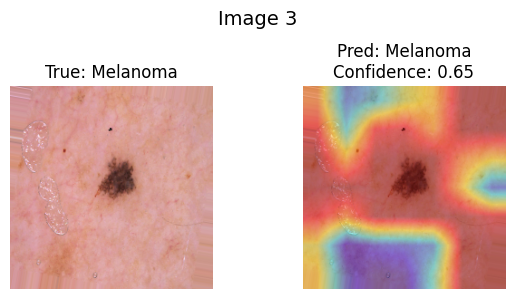

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


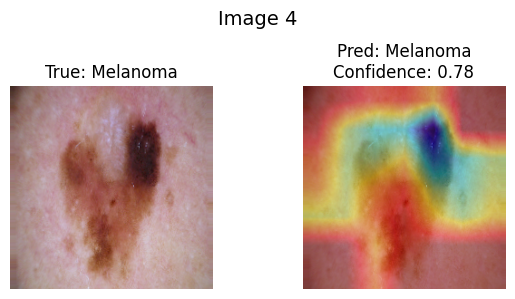

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


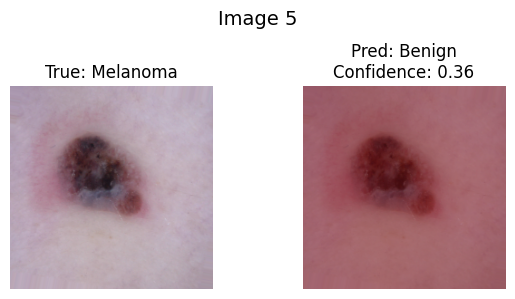

In [123]:
# Get one batch from validation generator
images, labels = validation_gen[0]

# Show Grad-CAMs for first 5 images
for i in range(5):
    show_gradcam(model, images[i], int(labels[i]), index=i)

In [124]:
model.save("skin_model.h5")

from google.colab import files
files.download("skin_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Specific Image from Dataset

True label: Benign


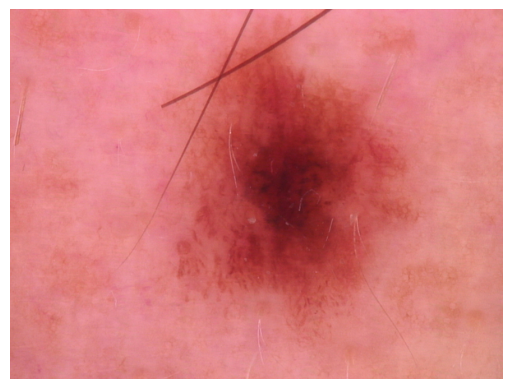

In [134]:
import matplotlib.pyplot as plt

image_id = 'ISIC_0024306'

row = df[df['image_id'] == image_id].iloc[0]
true_label = row['label']
print("True label:", "Melanoma" if true_label == 1 else "Benign")


def get_image_path(image_id):
  part1 = os.path.join('HAM10000_images_part_1', image_id + '.jpg')
  part2 = os.path.join('HAM10000_images_part_2', image_id + '.jpg')
  return part1 if os.path.exists(part1) else part2

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [129]:
from PIL import Image
import numpy as np

# Get full path to the image
img_path = get_image_path(image_id)

# Load and resize image
img = Image.open(img_path).convert('RGB')
img = img.resize((224, 224))
img_array = np.array(img) / 255.0  # Normalize

# Expand dims for prediction (model expects batch)
img_input = np.expand_dims(img_array, axis=0)


In [130]:
pred_prob = model.predict(img_input)[0][0]
pred_label = int(pred_prob > 0.5)

print(f"Predicted: {'Melanoma' if pred_label == 1 else 'Benign'} ({pred_prob:.2f} confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted: Melanoma (0.77 confidence)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1556']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


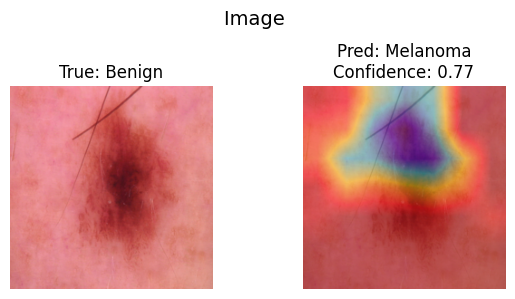

In [131]:
show_gradcam(model, img_array, true_label)
